## GoogleLeNet

Next, we'd like to construct GoogLeNet as described in the [original GoogLeNet paper](https://arxiv.org/abs/1409.4842) from scratch.

This part of the lab is adapted from [kuangliu's PyTorch CIFAR repository on GitHub](https://github.com/kuangliu/pytorch-cifar/blob/master/models/googlenet.py).

### GoogleLeNet

GoogleLeNet or Inception network is an important concept for development CNN classifier. Most of CNNs just stacked convolution deeper and deeper to get performance, but very deep networks are prone to overfitting. It also hard to pass gradient updates through the entire network, and make computation expensive. In the other hands, inception network do in wider path to improve performance.

<img src="figures/expandDeeper.jpg" style="width: 400px;" />

There are several versions of the inception networks such as Inception v1, Inception v2, Inception v3, Inception v4, and Inception-ResNet.

The full architecture of GoogLeNet (inception1) looks like this:

<img src="figures/GoogleLeNet.png" style="width: 1080px;" />

### Inception block

The key innovation introduced by GoogLeNet is the concept of the "inception" block. A standard inception block looks like this:

<img src="figures/inception.png" style="width: 600px;" />

### Auxiliary classifiers

To prevent the middle part of the network from “dying out”, the authors introduced two auxiliary classifiers (The purple boxes in the image). They essentially applied softmax to the outputs of two of the inception modules, and computed an auxiliary loss over the same labels. The total loss function is a weighted sum of the auxiliary loss and the real loss. Weight value used in the paper was 0.3 for each auxiliary loss.

$$ \mathcal{L}_{total} = \mathcal{L}_{Real} + 0.3 \mathcal{L}_{aux_1} + 0.3 \mathcal{L}_{aux_2}$$

### Inception v1 coding

Let's implement the architecture. 
Take a look at each element and see how it implements the concepts described in the paper.
First, we begin with a `Module` for an inception block with parameters that can be customized to implement each block in the overall network.

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F

In [2]:
class Inception(nn.Module):
    '''
    Inception block for a GoogLeNet-like CNN

    Attributes
    ----------
    in_planes : int
        Number of input feature maps
    n1x1 : int
        Number of direct 1x1 convolutions
    n3x3red : int
        Number of 1x1 reductions before the 3x3 convolutions
    n3x3 : int
        Number of 3x3 convolutions
    n5x5red : int
        Number of 1x1 reductions before the 5x5 convolutions
    n5x5 : int
        Number of 5x5 convolutions
    pool_planes : int
        Number of 1x1 convolutions after 3x3 max pooling
    b1 : Sequential
        First branch (direct 1x1 convolutions)
    b2 : Sequential
        Second branch (reduction then 3x3 convolutions)
    b3 : Sequential
        Third branch (reduction then 5x5 convolutions)
    b4 : Sequential
        Fourth branch (max pooling then reduction)
    '''
    
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.in_planes = in_planes
        self.n1x1 = n1x1
        self.n3x3red = n3x3red
        self.n3x3 = n3x3
        self.n5x5red = n5x5red
        self.n5x5 = n5x5
        self.pool_planes = pool_planes
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)


### The whole shebang

Now the whole shebang.

Note that kiangliu's version is intended for CIFAR-10, so it's assuming a small input image size (3x32x32). Also, there are no side classifiers.
In the exercises, you'll convert this to the ImageNet style 224x224 input.


In [3]:
class GoogLeNet(nn.Module):
    '''
    GoogLeNet-like CNN

    Attributes
    ----------
    pre_layers : Sequential
        Initial convolutional layer
    a3 : Inception
        First inception block
    b3 : Inception
        Second inception block
    maxpool : MaxPool2d
        Pooling layer after second inception block
    a4 : Inception
        Third inception block
    b4 : Inception
        Fourth inception block
    c4 : Inception
        Fifth inception block
    d4 : Inception
        Sixth inception block
    e4 : Inception
        Seventh inception block
    a5 : Inception
        Eighth inception block
    b5 : Inception
        Ninth inception block
    avgpool : AvgPool2d
        Average pool layer after final inception block
    linear : Linear
        Fully connected layer
    '''

    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Next, here are the Dataset and DataLoader objects from kiangliu. Notice the transforms may be more suitable for CIFAR-10 than the ImageNet transforms we implemented last week. But will they work as well?

In [43]:
# Preprocess inputs to 3x32x32 with CIFAR-specific normalization parameters
preprocess = transforms.Compose([
    transforms.Resize(36),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and set up train, validation, and test datasets with new preprocess object

train_dataset = torchvision.datasets.CIFAR10(
    root='./data/CIFAR10', train=True, download=True, transform=preprocess)

train_datset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data/CIFAR10', train=False, download=True, transform=preprocess)

# Create DataLoaders

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,   batch_size=128, shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,  batch_size=128, shuffle=False, num_workers=2)

dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Device 'cuda' or 'cuda:0' means GPU slot 0.
# If you have more than one GPU, you can select other GPUs using 'cuda:1', 'cuda:2', etc.
# In terminal (Linux), you can check memory using in each GPU by using command
# $ nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

### Training GoogLeNet

In [44]:
googlenet = GoogLeNet().to(device)
criterion_3 = nn.CrossEntropyLoss()
params_to_update_3 = googlenet.parameters()
optimizer_3 = optim.Adam(params_to_update_3, lr=0.01)

best_model3, val_acc_history3, loss_acc_history3 = train_model(googlenet, dataloaders, criterion_3, optimizer_3, 25, 'googlenet_lr_0.01_bestsofar')

Epoch 0/24
----------
train Loss: 1.7984 Acc: 0.3280
Epoch time taken:  57.16261053085327
val Loss: 1.5263 Acc: 0.4427
Epoch time taken:  61.11941456794739

Epoch 1/24
----------
train Loss: 1.2545 Acc: 0.5399
Epoch time taken:  57.586315393447876
val Loss: 1.4846 Acc: 0.4991
Epoch time taken:  61.55653524398804

Epoch 2/24
----------
train Loss: 0.9673 Acc: 0.6539
Epoch time taken:  57.8440215587616
val Loss: 0.9725 Acc: 0.6465
Epoch time taken:  61.82408428192139

Epoch 3/24
----------
train Loss: 0.7916 Acc: 0.7185
Epoch time taken:  57.96931767463684
val Loss: 0.7206 Acc: 0.7408
Epoch time taken:  61.95615220069885

Epoch 4/24
----------
train Loss: 0.6533 Acc: 0.7708
Epoch time taken:  57.978909492492676
val Loss: 0.6759 Acc: 0.7652
Epoch time taken:  61.97967720031738

Epoch 5/24
----------
train Loss: 0.5603 Acc: 0.8032
Epoch time taken:  57.98308825492859
val Loss: 0.6697 Acc: 0.7624
Epoch time taken:  61.9776771068573

Epoch 6/24
----------
train Loss: 0.4842 Acc: 0.8315
Epoch

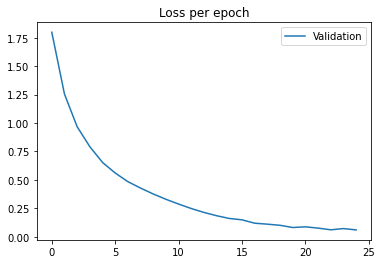

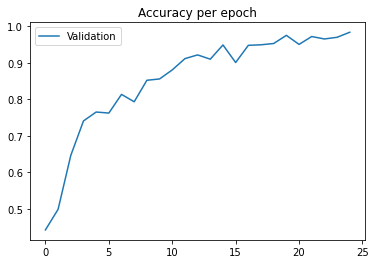

In [45]:
plot_data(val_acc_history3, loss_acc_history3)